# Example for Comparator.py

In [27]:

import functions as f
from similarity.DataFrameMetadataCreator import DataFrameMetadataCreator
from similarity.DataFrameMetadata import DataFrameMetadata
from collections import defaultdict
from similarity.Comparator import Comparator
import pandas as pd
from similarity.Comparator import CategoricalComparator, ColumnEmbeddingComparator

## Load Data

In [28]:
database, names = f.load__csv_files_from_folder("../data")
# database, names = f.load__csv_files_from_folder("../data_validation")

In [29]:
names

['aircraft-data_nov_dec',
 'Airplane_Cleaned',
 'autoscout24-germany-dataset',
 'CARS_1',
 'disney_movies',
 'exchange_rates',
 'imdb_top_1000',
 'netflix_titles',
 'Sales_Transaction10000',
 'transaction_data',
 'USA_cars_datasets']

## Define similar Tables

In [30]:
aircraft_car_movies = {
        "aircraft-data_nov_dec": ("Airplane_Cleaned","aircraft-data_nov_dec"),
        "Airplane_Cleaned": ("aircraft-data_nov_dec","Airplane_Cleaned"),
        "autoscout24-germany-dataset": ("CARS_1", "USA_cars_datasets",  "autoscout24-germany-dataset"),
        "CARS_1": ("autoscout24-germany-dataset", "USA_cars_datasets", "CARS_1"),
        "USA_cars_datasets": ("autoscout24-germany-dataset", "CARS_1", "USA_cars_datasets"),
        "disney_movies": ("imdb_top_1000", "netflix_titles", "disney_movies"),
        "imdb_top_1000": ("disney_movies", "netflix_titles", "imdb_top_1000"),
        "netflix_titles": ("disney_movies", "imdb_top_1000",  "netflix_titles"),
        "exchange_rates": ("Sales_Transaction10000", "transaction_data", "exchange_rates"),
        "Sales_Transaction10000": ("exchange_rates", "transaction_data", "Sales_Transaction10000"),
        "transaction_data": ("exchange_rates", "Sales_Transaction10000", "transaction_data")
    }

In [31]:
sales_wine_educ = {
    "amazon": ("amazon","vgsales", "supermarket_sales"),
    "supermarket_sales": ("amazon","vgsales", "supermarket_sales"),
    "vgsales": ("amazon","vgsales", "supermarket_sales", "steam", "games"),
    "games": ("vgsales", "steam", "games"),
    "steam": ("vgsales", "steam", "games"),
    "exams": ("exams", "states_all", "SAT_california", "mathScore"),
    "states_all": ("exams", "states_all", "SAT_california", "mathScore"),
    "SAT_california": ("exams", "states_all", "SAT_california", "mathScore"),
    "mathScore": ("exams", "states_all", "SAT_california", "mathScore"),
    "winequality-red": ("winequality", "winequality-red"),
    "winequality": ("winequality", "winequality-red"),
}

In [32]:
corr_doubles = aircraft_car_movies
# corr_doubles = sales_wine_educ

## Creates metadata

In [49]:
metadata: dict[str, DataFrameMetadata] = defaultdict()
for dataframe, name in zip(database, names):
    metadata[name] = (DataFrameMetadataCreator(dataframe).
                      create_column_embeddings()
                      .compute_column_kind()
                      .compute_advanced_structural_types()
                      .get_metadata())
    

C:\Users\ab032mj\Desktop\thesis\simillarity\venv\Lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname AG identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
C:\Users\ab032mj\Desktop\thesis\simillarity\venv\Lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname ELSIE identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
C:\Users\ab032mj\Desktop\thesis\simillarity\venv\Lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version

In [50]:
def compare_dataset(metadata_: dict[str, DataFrameMetadata], comparator_: Comparator ) -> pd.DataFrame:
    result = pd.DataFrame()
    for name1, metadata1 in  metadata_.items():
        for name2, metadata2 in metadata_.items():
            sim = comparator_.compare(metadata1, metadata2)
            result.loc[name1, name2] = sim
            # print(f"Distance between {name1} and {name2} is {sim}")
    return result

In [51]:
def compute_accuracy(dist_matrix: pd.DataFrame):
    trashold = 0.5
   # max je 31 * score_add + 90
    score = 0
    only_good = 0
    count = 0
    for rowIndex, row in dist_matrix.iterrows(): 
        for columnIndex, value in row.items():
            count += 1
            if value <= trashold and columnIndex in corr_doubles[rowIndex]:
                # score += 2
                score += 1
                only_good +=1
            # elif value <= trashold and columnIndex not in corr_doubles[rowIndex]:
            #     score -= 1
            # elif value > trashold and columnIndex in corr_doubles[rowIndex]:
            #     score -= 2
            elif value > trashold and columnIndex not in corr_doubles[rowIndex]:
                score += 1
    return score/count, only_good
    

## Compute accuracy
- accuracy is computed for each comparator for all columns
- it computes score that depends on defined similar tables.
- for each comparator we get only one score, the higher, the better.

In [ ]:
comparatorEmbd = Comparator().add_comparator_type(ColumnEmbeddingComparator())
result_only_embedding = compare_dataset(metadata, comparatorEmbd) 
print(f"Accuracy for embedding for all columns: {compute_accuracy(result_only_embedding)} ")
            

In [53]:
comparator_cat = Comparator().add_comparator_type(CategoricalComparator())
result_categorical = compare_dataset(metadata, comparator_cat)
print(f"Accuracy for categorical: {compute_accuracy(result_categorical)} ")

KeyError: 'manufacturer'

In [ ]:
comparator_both = Comparator().add_comparator_type(ColumnEmbeddingComparator()).add_comparator_type(CategoricalComparator())

resultBoth = compare_dataset(metadata, comparator_both)
print(f"Accuracy for both: {compute_accuracy(resultBoth)} ")

In [ ]:
from similarity.Comparator import CategoricalComparatorSimilar

comparator_cat_sim = Comparator().add_comparator_type(CategoricalComparatorSimilar())
result_categorical_sim = compare_dataset(metadata, comparator_cat_sim)
print(f"Accuracy for categorical sim : {compute_accuracy(result_categorical_sim)} ")

In [ ]:
comparator_both_sim = Comparator().add_comparator_type(ColumnEmbeddingComparator()).add_comparator_type(CategoricalComparatorSimilar())

resultBoth_sim = compare_dataset(metadata, comparator_both_sim)
print(f"Accuracy for both: {compute_accuracy(resultBoth_sim)} ")

## Plot similarity between columns

In [56]:
result_only_embedding

,aircraft-data_nov_dec,Airplane_Cleaned,autoscout24-germany-dataset,CARS_1,disney_movies,exchange_rates,imdb_top_1000,netflix_titles,Sales_Transaction10000,transaction_data,USA_cars_datasets
aircraft-data_nov_dec,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Airplane_Cleaned,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
autoscout24-germany-dataset,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CARS_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
disney_movies,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
exchange_rates,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
imdb_top_1000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
netflix_titles,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Sales_Transaction10000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
transaction_data,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<Axes: >

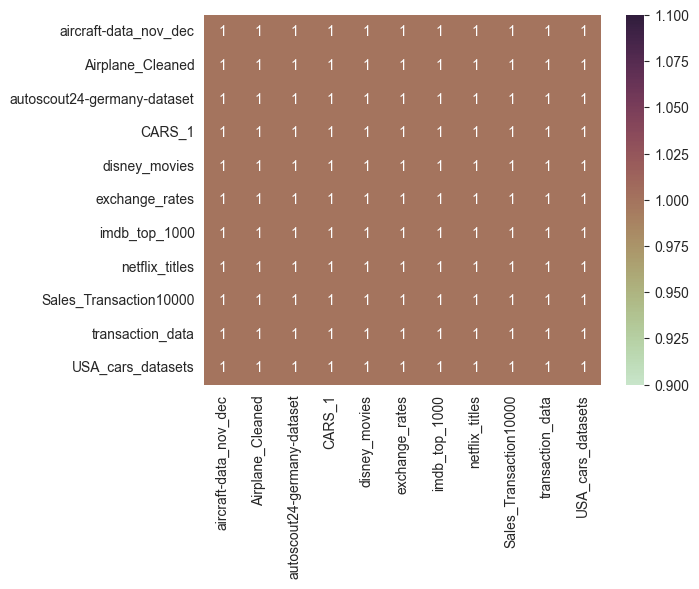

In [44]:
import seaborn as sns
sns.heatmap(result_only_embedding, annot=True, cmap= sns.color_palette("ch:s=-.1,r=.8", as_cmap=True))

<Axes: >

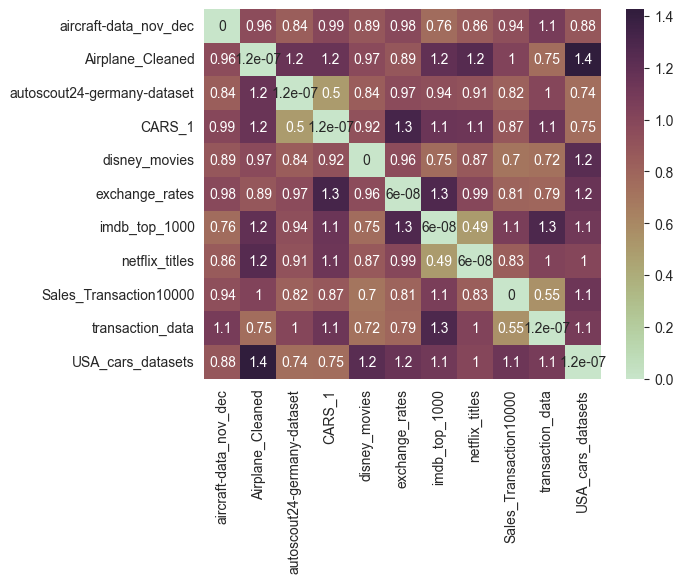

In [16]:
sns.heatmap(resultBoth, annot=True, cmap= sns.color_palette("ch:s=-.1,r=.8", as_cmap=True))

<Axes: >

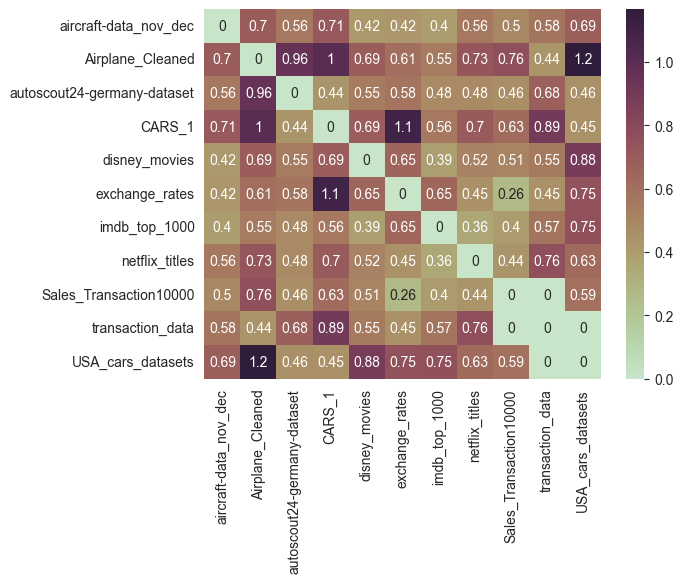

In [17]:
sns.heatmap(result_categorical, annot=True, cmap= sns.color_palette("ch:s=-.1,r=.8", as_cmap=True))

<Axes: >

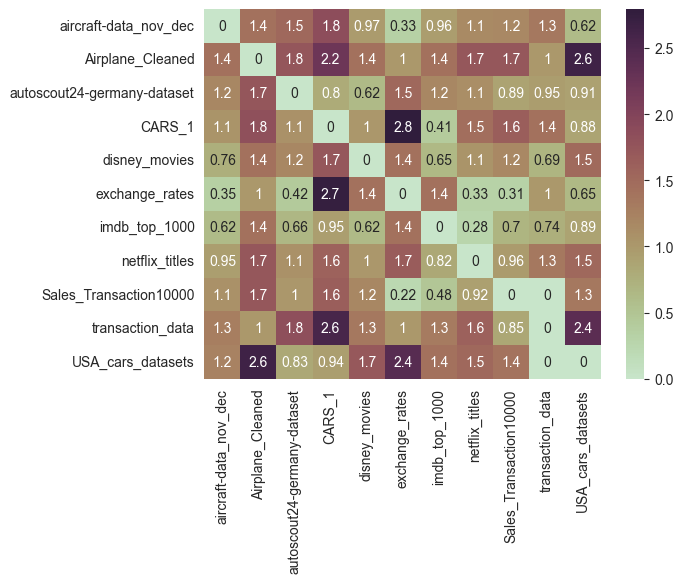

In [18]:
sns.heatmap(result_categorical_sim, annot=True, cmap=
            sns.color_palette("ch:s=-.1,r=.8", as_cmap=True))

In [19]:
#  sns.color_palette("ch:s=-.1,r=.8", as_cmap=True)
# sns.color_palette("ch:s=3,r=0.9, h=0.9", as_cmap=True)


<Axes: >

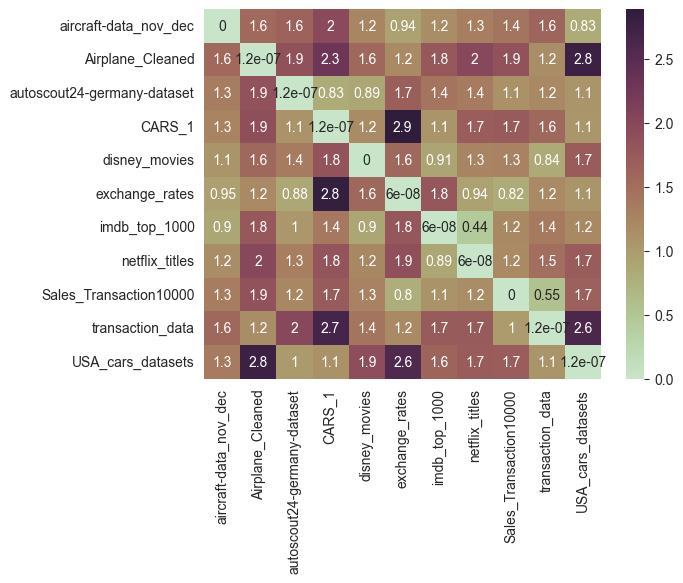

In [20]:
sns.heatmap(resultBoth_sim, annot=True, cmap=
            sns.color_palette("ch:s=-.1,r=.8", as_cmap=True))